In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
import json
import os
import networkx as nx

from tqdm import tqdm
# initialize tqdm for pandas
tqdm.pandas()

from helpers import *
# turn off the SettingWithCopyWarning
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

In [2]:
DIR = os.getcwd()

# raw data
RAW = "\data\\raw"
PATH_DF_CHANNELS = DIR + RAW + '\\df_channels_en.tsv.gz' # 6 mb
PATH_DF_TIMESERIES = DIR + RAW + '\\df_timeseries_en.tsv.gz' # 571 mb
PATH_YT_METADATA = DIR + RAW + '\\yt_metadata_en.jsonl.gz' # 13.6 gb
PATH_NUM_COMMENTS = DIR + RAW + '\\num_comments.tsv.gz' # 754 mb

# clean data
CLEAN = "\data\\clean"
PATH_YT_TECH_EDU_METADATA = DIR + CLEAN + '\\yt_tech_edu_metadata_en.tsv.gz'
PATH_YT_TECH_CHANNELS_METADATA = DIR + CLEAN + '\\yt_tech_channels_metadata.tsv.gz'
PATH_TECH_CHANNELS = DIR + CLEAN + '\\tech_review_channels.tsv.gz'
PATH_TECH_VIDEOS = DIR + CLEAN + '\\tech_review_videos.tsv.gz'

In [3]:
df_tech_review_mt = pd.read_csv(PATH_YT_TECH_CHANNELS_METADATA, sep="\t", compression="infer")
df_tech_review_mt = df_tech_review_mt.drop('Unnamed: 0',axis=1)
df_tech_review_channels = pd.read_csv(PATH_TECH_CHANNELS, sep="\t", compression="infer")
df_tech_review_channels = df_tech_review_channels.drop('Unnamed: 0',axis=1)

In this section, we are going to analyze if covering a wider range of tech products is more effective to gain more subscribers, or should the channels focus on a specific type of tech.

Here, we are assessing 3 tech types, such as phone, camera, and laptop, and we are classifying videos into one of these 3 (or none), depending on some keywords that are relevant to these tech types. Then for each channel, we are calculating the percentage of camera, phone, and laptop videos:

### The most common product

In [185]:
# Define the filename for the JSON file
keywords_path = DIR + CLEAN + '\\product_keywords.json'

# Read the keywords from the JSON file
with open(keywords_path, 'r') as file:
    keywords = json.load(file)

# get the product types
products = list(keywords.keys())
print(products)

['laptop', 'phone', 'camera', 'headphone', 'smart_watches', 'tablet', 'desktop_setup']


In [5]:
tech_df_mt = df_tech_review_mt.copy()

# 2 videos are missing title, so we ignore them
tech_df_mt = tech_df_mt[tech_df_mt.title.notna()]

# classify the video into laptop, phone, camera
tech_df_mt['product_category'] = tech_df_mt.title.apply(lambda title: classify_product(title.lower(), keywords))

# drop the videos that are not classified as either one of the product types
tech_df_prd = tech_df_mt[tech_df_mt.product_category.notna()]
print("Number of videos in metadata: ", tech_df_mt.shape[0])
print("Number of videos about either of the products: ", tech_df_prd.shape[0])

# get the percentage of videos in each categorie per channel
tech_df_prd_count = tech_df_prd.groupby(['channel_id','product_category'],as_index=False)[['display_id']].count().pivot(index='channel_id',columns='product_category',values='display_id').fillna(0)
tech_df_prd_perc = tech_df_prd_count.divide(tech_df_prd_count.sum(axis=1),axis=0)
display(tech_df_prd_perc.sample(5))

Number of videos in metadata:  740016
Number of videos about either of the products:  516660


product_category,camera,desktop_setup,headphone,laptop,phone,smart_watches,tablet
channel_id,,,,,,,
UCk1SpWNzOs4MYmr0uICEntg,0.026926,0.037397,0.025430,0.049364,0.810022,0.009723,0.041137
UCF8kWC5EHipzFEhEwsASrEg,0.136905,0.041667,0.026190,0.057143,0.696429,0.008333,0.033333
UCjJYD85vaiBowhJNqY_pZOw,0.069686,0.163763,0.397213,0.055749,0.125436,0.006969,0.181185
UC-NXC-hJ5Y7i6s8ta2nQMSw,0.000000,0.291667,0.020833,0.437500,0.166667,0.000000,0.083333
UCviAcL8AlEoGqLDWx7t_iPw,0.083333,0.000000,0.000000,0.000000,0.916667,0.000000,0.000000


Let's see in what categories more successful YouTubers tend to produce tech review videos by plotting the moving average (with window size of 50) of product type percentages over the rank of the YouTubers.

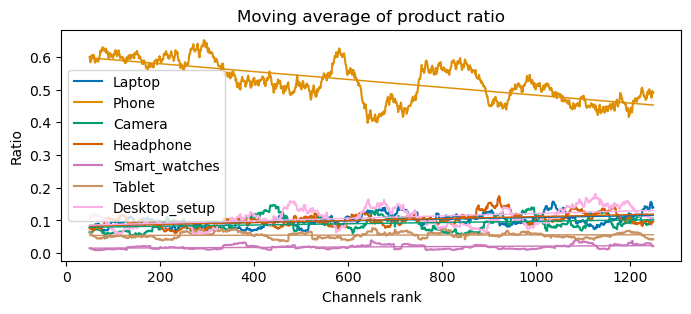

In [6]:
# define a new rank to the channels depending on its number of subscribers
df_tech_review_channels['new_rank'] = pd.Series(range(1, df_tech_review_channels.shape[0]+1))

# flag the channels with wide/narrow range of tech products to be used later
tech_df_prd_perc.loc[tech_df_prd_perc.apply(lambda df: any(df[p] > 0.8 for p in products), axis=1),'wide_range'] = 0
tech_df_prd_perc['wide_range'].fillna(1, inplace=True)

# merge
channels_rank = pd.merge(df_tech_review_channels[['subscribers_cc','channel_id','new_rank']],tech_df_prd_perc,on='channel_id',how='right').sort_values(by='new_rank',ascending=True).reset_index(drop=True)

# moving average of category percentage per rank
colors = sns.color_palette("colorblind",len(products))
plt.figure(figsize=(8,3))

# plot moving average
for idx,product in enumerate(products):
    ax = sns.lineplot(x=channels_rank['new_rank'], y=channels_rank[product].rolling(50).mean(), label=product.capitalize(),color=colors[idx])

# Add regression lines
for idx,product in enumerate(products):
    sns.regplot(x=channels_rank['new_rank'], y=channels_rank[product].rolling(50).mean(), scatter=False, ax=ax, color=colors[idx], line_kws={'linewidth': 1})

ax.set(title='Moving average of product ratio', xlabel='Channels rank', ylabel='Ratio')
plt.legend()
plt.show()


As we can see, most channels tend to focus on phones. It just means phones are a commont topic to focus on, but we still need to see (in the next section) how it actually influences the channel's growth.

Below, we analyze the effect of covering wider/narrow range of products on the number of subscriber. But before that we want to balance the dataset on some metrics, namely average duration of videos per channel, and the delay in time between publishing 2 sequential videos. Below, we compute these metrices per video, and compute their micro averages.

### Range of products to cover

In [21]:
# define average upload frequency per channel
tech_mt_uf = df_tech_review_mt.copy()
tech_mt_uf['upload_date'] = pd.to_datetime(tech_mt_uf.upload_date)
tech_mt_uf.sort_values(by=['channel_id','upload_date'],ascending=True,inplace=True)
tech_mt_uf['delay'] = tech_mt_uf.upload_date - tech_mt_uf.shift(1).upload_date
# set all first uploads to 0
first_upload = tech_mt_uf.groupby('channel_id',as_index=False)[['upload_date']].min()
first_upload['is_first'] = True
tech_df_upload_freq = pd.merge(tech_mt_uf,first_upload,on=['channel_id','upload_date'],how='left')
tech_df_upload_freq.is_first.fillna(False,inplace=True)
tech_df_upload_freq.loc[tech_df_upload_freq.is_first,'delay'] = pd.Timedelta(seconds=0)
tech_df_upload_freq['upload_year'] = tech_df_upload_freq.upload_date.dt.year
tech_df_upload_freq['upload_month'] = tech_df_upload_freq.upload_date.dt.month
tech_df_avg = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['delay']].mean().groupby(['channel_id','upload_year'],as_index=False)[['delay']].mean().groupby(['channel_id'],as_index=False)[['delay']].mean()
tech_df_avg.rename({'delay':'avg_delay'},axis=1,inplace=True)
tech_df_avg.avg_delay = (tech_df_avg.avg_delay / np.timedelta64(1, 'D')).astype(float)

# define average duration
tech_df_avg_dur = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['duration']].mean().groupby(['channel_id','upload_year'],as_index=False)[['duration']].mean().groupby(['channel_id'],as_index=False)[['duration']].mean()
tech_df_avg_dur.rename({'duration':'avg_duration'},axis=1,inplace=True)

# get the total number of views per channel
view_sum = df_tech_review_mt.groupby('channel_id',as_index=False)[['view_count']].sum().rename({'view_count':'view_sum'},axis=1)

# define dataframe for observational study
df_obs = pd.merge(df_tech_review_channels[['channel_id','subscribers_cc']],tech_df_avg_dur,on='channel_id',how='left')
df_obs = pd.merge(df_obs,tech_df_avg,on='channel_id',how='left')
df_obs = pd.merge(df_obs,channels_rank[['channel_id','wide_range']],on='channel_id',how='right')
df_obs = pd.merge(df_obs,view_sum,on='channel_id',how='left')
df_obs.loc[df_obs['wide_range'],'wide_range'] = 1
df_obs.loc[df_obs['wide_range'] != 1,'wide_range'] = 0
df_obs['wide_range'] = df_obs['wide_range'].astype(int)
print("# of 'wide' channels: {}".format(df_obs.wide_range.sum()))
print("# of 'narrow' channels: {}".format(df_obs.wide_range.count() - df_obs.wide_range.sum()))
display(df_obs.sample(5))

# of 'wide' channels: 958
# of 'narrow' channels: 290


,channel_id,subscribers_cc,avg_duration,avg_delay,wide_range,view_sum
787,UCjtakVAGquXU74GthNKdCYQ,33800,397.052751,9.734757,1,13815484.0
458,UCTkMl64iMrMFpUO9a0WTmCw,97090,386.825842,23.965551,1,10080542.0
597,UC9CBe29XCDl9JrWstKbBnRA,49900,195.828317,128.775473,0,14115840.0
1205,UCgXmhbyG0qyRAUvqXXoWyoQ,10000,705.614917,14.335276,1,3502231.0
1032,UCd8_HyWNvLELqVg2QIoXPAA,17300,1185.606831,47.483965,1,5310292.0


Here we balance the two groups on the above-defined metrices, and see the distribution of the number of subscribers and total views of 2 groups.

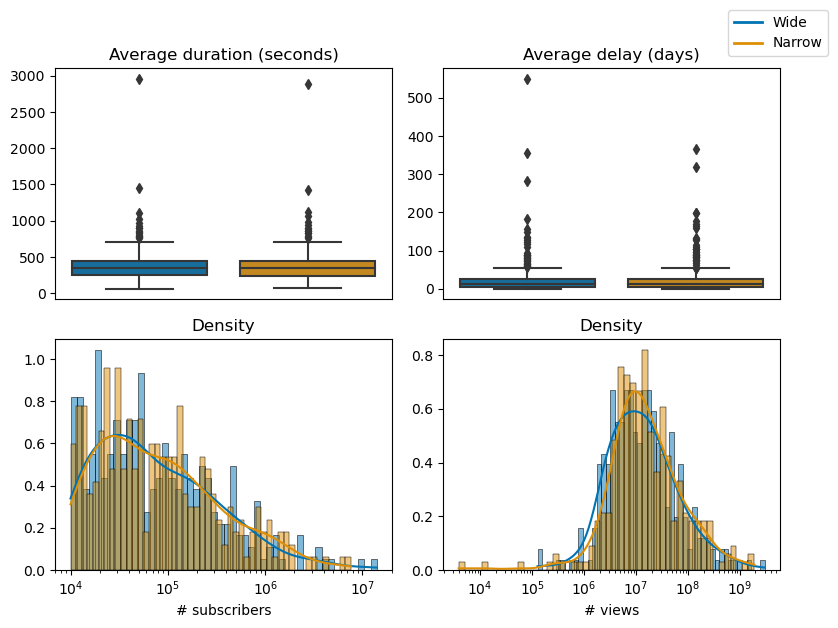

In [47]:
# balance the treat and control groups
match_idx = balance_data(df=df_obs,treat_column='wide_range',continuous_features=['avg_duration','avg_delay'])
df_obs_matched = df_obs.iloc[match_idx]

# plot
colors = sns.color_palette("colorblind",2)
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(8,6))

sns.boxplot(y=df_obs_matched['avg_duration'],x=df_obs_matched['wide_range'],ax=axes[0][0],palette=colors)
sns.boxplot(y=df_obs_matched['avg_delay'],x=df_obs_matched['wide_range'],ax=axes[0][1],palette=colors)
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 1]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[1][0],color=colors[0])
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 0]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[1][0],color=colors[1])
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 1]['view_sum'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[1][1],color=colors[0])
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 0]['view_sum'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[1][1],color=colors[1])

axes[0][0].set(title='Average duration (seconds)',xlabel=None,ylabel=None,xticks=[])
axes[0][1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
axes[1][0].set(title='Density',xlabel='# subscribers',ylabel=None)
axes[1][1].set(title='Density',xlabel='# views',ylabel=None)

# Create custom legend handles with Line2D objects
legend_handles = [Line2D([0], [0], color=colors[0], lw=2),
                  Line2D([0], [0], color=colors[1], lw=2)]

# Use the custom handles in the legend
fig.legend(handles=legend_handles, labels=['Wide', 'Narrow'], bbox_to_anchor=(1.05, 1.05))
plt.tight_layout()
plt.show()

From the above distribution of 'narrow' and 'wide' channels, we can see non of the 2 groups is clearly outperforming the other. To see it more clearly we can also check the statistical difference between the 2 groups:

In [48]:
wide = df_obs_matched[df_obs_matched['wide_range']==1]
narrow = df_obs_matched[df_obs_matched['wide_range']==0]

# statistical difference between the number of subscribers and the total views respectively of the 2 groups
print(ttest_ind(narrow['subscribers_cc'],wide['subscribers_cc']))
print(ttest_ind(narrow['view_sum'],wide['view_sum']))

Ttest_indResult(statistic=-0.4449572010193068, pvalue=0.6565172625225137)
Ttest_indResult(statistic=0.14304780797449437, pvalue=0.886302277149428)


Because both pvalues > 0.05, we cannot reject the null hypothesis that is the mean number of subscribers/views of the "narrow" and "wide" channels are the same, meaning whether or not a channels focuses on a single product review, or covers a wider range of products, it does not have a direct influence on the growth of the channel, i.e. number of subscribers/views.

### Which product has higher influence on the channels' growth?

Here, we only fitler the top channels that focus on wider range fo product types and see which ones of the product categories usually go together and bring them more views.

In [184]:
# filter only the channels that focus on wider range of products and with over 100000 subscribers
top_wide = channels_rank[(channels_rank.wide_range==1) & (channels_rank.subscribers_cc > 100000)].channel_id.unique()
print('# channels:',len(top_wide))
tech_df_graph = tech_df_prd[tech_df_prd.channel_id.isin(top_wide)][['channel_id','display_id','product_category','like_count','dislike_count','view_count']].copy()

# set the product categories as the node of the graph, and average # views in each category as the size of the node
node_size = tech_df_graph.groupby('product_category',as_index=False)[['view_count']].mean()

# for each channel assign the product categories that they cover as a list
all_products = tech_df_graph.groupby(['channel_id'],as_index=False)[['product_category']].agg(lambda prd: set(prd))
all_products = pd.merge(all_products, channels_rank[['subscribers_cc','channel_id']], on='channel_id', how='left')
display(all_products.head(5))


# channels: 338


,channel_id,product_category,subscribers_cc
0,UC-tZk0bsaiq9KANWZ2BPO8w,"{tablet, desktop_setup, headphone, camera, pho...",197000
1,UC-v54XQalOcx5yco3aTixrg,"{tablet, desktop_setup, headphone, camera, pho...",159000
2,UC04dfXeTsgROBHSLm_C__JA,"{tablet, desktop_setup, headphone, camera, pho...",106000
3,UC07rNeWO01xLjyNMY5cLo2A,"{tablet, desktop_setup, headphone, camera, pho...",103000
4,UC0AlsCTfOpk8mB2Nd29ZZSg,"{desktop_setup, headphone, camera, phone, lapt...",131000


We create a graph only for the sake of visualization where:
- nodes -> product categories
- nodes size -> average number of views of that category
- edge -> if both nodes (products) have been uploaded by the same channel
- edge color -> number of channels that have uploaded both of the corresponding products

By doing that we can see which pair(s) of products usually go together:

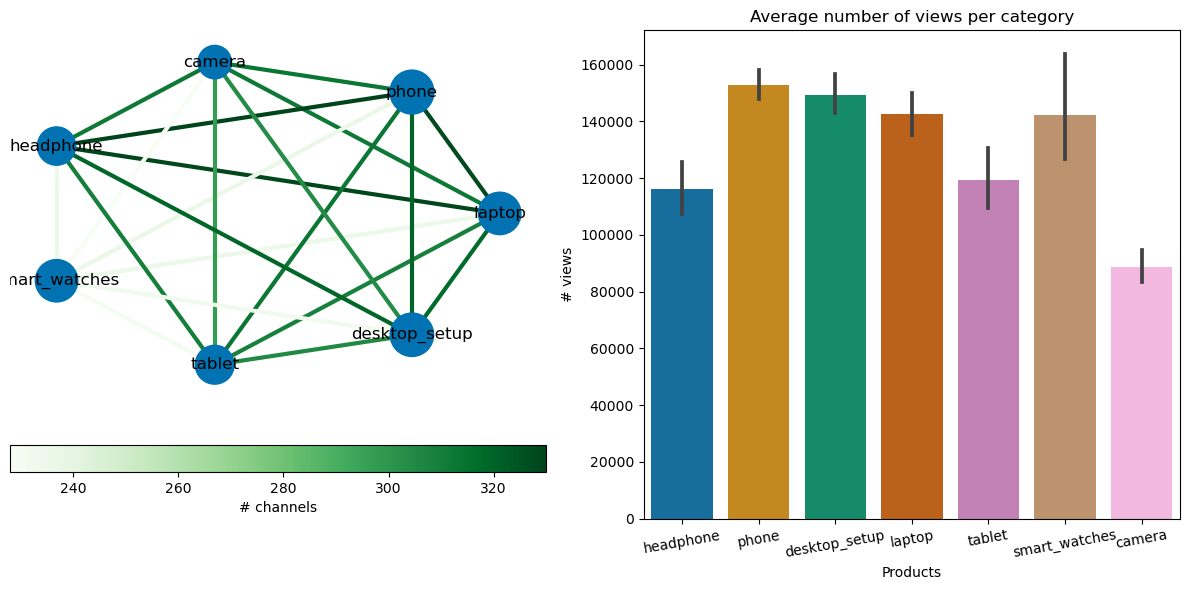

In [269]:
# Helper function for visualizing the graph
def visualize_graph(G, ax, with_labels=True, alpha=1.0):
    # get the circular layout
    pos = nx.circular_layout(G, center=[1,1]) 

    if with_labels:
        labels = {node: f"{node}" for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels=labels, ax=ax)

    # plot edges with weights
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha, edgelist=edges, edge_color=weights, width=3, ax=ax, edge_cmap=plt.cm.Greens)

    # Add color bar for edge weights
    cbar = plt.colorbar(ec, orientation='horizontal', pad=0.1, ax=ax)
    cbar.set_label('# channels')

    # plot nodes with size
    color = sns.color_palette("colorblind",1)
    nodes,size = zip(*nx.get_node_attributes(G,'size').items())
    nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, node_size=1000*np.divide(list(size),max(list(size))), ax=ax)

# create graph
G = nx.Graph()

for _,row in all_products.iterrows():

    # add node
    for product in list(products):
        G.add_node(
            product, 
            size=node_size[node_size['product_category']==product]['view_count'].iloc[0] # mean view as node size
        )

    # add edge
    for i in range(len(products)):
        for j in range(i+1, len(products)):
            if (products[i] in row['product_category']) & (products[j] in row['product_category']):
                if G.has_edge(products[i], products[j]):
                    G[products[i]][products[j]]['weight'] += 1  # update the weight of the existing edge
                else:
                    G.add_edge(products[i], products[j], weight=1)  # add a new edge with weight 1

# visualize the plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
colors = sns.color_palette("colorblind",len(products))

visualize_graph(G,with_labels=True,ax=axes[0])
sns.barplot(data=tech_df_graph, x='product_category', y='view_count', estimator='mean', ax=axes[1], palette=colors)

axes[0].axis('off')
axes[1].set(title='Average number of views per category', xlabel='Products', ylabel='# views')
axes[1].tick_params(axis='x', rotation=10)

plt.tight_layout()
plt.show()

From the above graph we can see that the videos about phones, headphones and laptops have stronger bond compared to the other pairs, meaning most of the successful channels tend to cover the combination of these products.

### Which product attracts more viewers

For each video uploaded, let's get the ratio of the number of views of the video to the total number of views of the channel at the time of release of the video. Then, we want to see if any one of the products have a clearly higher ratio of views compared to the others:

In [208]:
# import the timeseries dataset
timeseries = pd.read_csv(PATH_DF_TIMESERIES, sep="\t", compression="infer")

# Helper function to find the index of the closest datetime
def find_closest_datetime_index(row):
    row_diff = row.copy()
    row_diff = row_diff[row_diff['upload_date'] - row_diff['datetime'] >= pd.Timedelta(0)]
    if not row_diff.empty:
        # If row_diff is not empty, return the index of the maximum datetime
        return row_diff['datetime'].idxmax()
    else:
        # If row_diff is empty, return the index of the minimum absolute time difference
        return (row['datetime'] - row['upload_date']).abs().idxmin()

# filter only the channels that focus on wider range of products and with over 100000 subscribers
top_timeseries = timeseries[timeseries.channel.isin(top_wide)]
top_videos = tech_df_prd[tech_df_prd.channel_id.isin(top_wide)]

# correct the datetime objects
top_timeseries.datetime = pd.to_datetime(top_timeseries.datetime)
top_timeseries.rename({'channel':'channel_id'},axis=1, inplace=True)
top_videos.upload_date = pd.to_datetime(top_videos.upload_date)

# merge the timeseies data of each videos
top_mt = pd.merge(top_videos[['channel_id','display_id','upload_date','view_count','product_category']],top_timeseries[['channel_id','datetime','views']],on='channel_id',how='left')
top_mt = top_mt[top_mt['upload_date']>=top_timeseries.datetime.min()]

# drop the channels with no timeseries data available
top_mt = top_mt[top_mt['datetime'].notna()]

# Group by 'channel_id' and find the index of the closest datetime for each group
closest_indices = top_mt.groupby('display_id').apply(find_closest_datetime_index)

# Get the corresponding rows from the original DataFrame
top_each = top_mt.loc[closest_indices]

# Get the views ratio
top_each['view_ratio'] = top_each['view_count'] / top_each['views']
display(top_each.sample(5))

,channel_id,display_id,upload_date,view_count,product_category,datetime,views,view_ratio
27828855,UC-tZk0bsaiq9KANWZ2BPO8w,QLmGxWj_c6g,2018-04-24,74207.0,smart_watches,2018-04-23 00:00:00,1.165684e+07,0.006366
1401475,UCpvg0uZH-oxmCagOWJo9p9g,ZdEG7UUwUDc,2016-11-14,32016.0,laptop,2016-11-13 23:00:00,6.517937e+07,0.000491
1467961,UCpvg0uZH-oxmCagOWJo9p9g,4aVh-nkeDUA,2019-09-08,1945327.0,laptop,2019-09-02 00:00:00,1.428913e+08,0.013614
23288733,UC7xdLQYOpbYuLpAfGwLN6Kw,cD8TdUMMkow,2019-09-16,39236.0,phone,2019-09-16 00:00:00,4.307658e+07,0.000911
19347063,UCGN_04Loctqx4yk2BBPDSiA,0zwAFEx5FaI,2017-08-24,37.0,phone,2017-08-21 01:00:00,1.027656e+04,0.003600


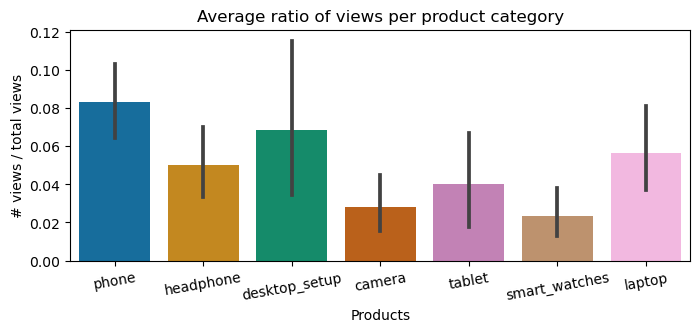

In [265]:
# plot the average ratio of views per product category
plt.figure(figsize=(8,3))
colors = sns.color_palette("colorblind",len(products))

ax = sns.barplot(
    data=top_each,
    x='product_category',
    y='view_ratio',
    estimator='mean',
    palette=colors
)
ax.set(title='Average ratio of views per product category', xlabel='Products', ylabel='# views / total views')

plt.xticks(rotation=10)
plt.show()

Here, we can see that no single product is totally outperforming the other. However it is worth mentioning that the phones tend to attract more viewers compared to the camera and smart watches.

To put it all together, we can derive the following conclusions:
1. There is not statistical difference in the number of subscriber and total views of the channels that focus on a particular tech product and those that cover a wider range of products, meaning it does not have a noticeable influence on the channels' growth.
2. Among the successful channels that cover a wider range of tech products, the ones that attract a more viewers are _Phones_, _Desktop setup_, _Laptop_, and _Headphones_ (in the order of importance), and usually successful channels tend to produce the videos in the combination of Phones, Laptop, and Headphones.